In [197]:
import madpose
from madpose.utils import compute_pose_error, get_depths
import json
import os

from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image
import torch

from romatch import roma_indoor


from transformers import (
    AutoModelForMaskGeneration,
    AutoProcessor,
    DepthProForDepthEstimation,
    DepthProImageProcessorFast,
    SamModel,
    SamProcessor,
    pipeline,
)

from ram.models import ram_plus, ram, tag2text

from ram import inference_ram 
from ram import get_transform

In [198]:
# 1. Configure RANSAC options
options = madpose.HybridLORansacOptions()
options.min_num_iterations = 100
options.max_num_iterations = 1000
options.success_probability = 0.9999
options.random_seed = 0
options.final_least_squares = True
options.threshold_multiplier = 5.0
# Set reprojection (e.g., 4px) and epipolar error thresholds
options.squared_inlier_thresholds = [4.0**2, 4.0**2] 
options.data_type_weights = [1.0, 1.0]

# 2. Configure Estimator settings
est_config = madpose.EstimatorConfig()
est_config.min_depth_constraint = True # Ensures positive depth
est_config.use_shift = True            # Models depth shift
est_config.ceres_num_threads = 8       # Set to number of physical CPU cores

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [199]:
sample_path = "frames"
img_path0=os.path.join(sample_path, "frame_0060.png")
img_path1=os.path.join(sample_path, "frame_0061.png")

img0 = Image.open(img_path0)
img1 = Image.open(img_path1)
W_0, H_0 = img0.size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pp0 = (np.array(np.array(img0).shape[:2][::-1]) - 1) / 2
pp1 = (np.array(np.array(img1).shape[:2][::-1]) - 1) / 2
pp = pp0

In [200]:
# model ini

roma_model = roma_indoor(device="cuda")

depth_image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
depth_model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

from pathlib import Path
from huggingface_hub import hf_hub_download
import torch
from ram.models import ram_plus

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = hf_hub_download(
    repo_id="xinyu1205/recognize-anything-plus-model",
    filename="ram_plus_swin_large_14m.pth",
)
assert Path(ckpt_path).is_file()

ram_model = ram_plus(
    pretrained=ckpt_path,
    image_size=384,
    vit="swin_l",
).eval().to(device)

segmenter_id = "facebook/sam-vit-base"

segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
processor = AutoProcessor.from_pretrained(segmenter_id)

detector_id = "IDEA-Research/grounding-dino-tiny"
object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)




2026-01-05 12:17:28.328 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 864)


--------------
/home/haoming/.cache/huggingface/hub/models--xinyu1205--recognize-anything-plus-model/snapshots/84d4aee3a0265c4e0df1f714f0572011d1bf2ec3/ram_plus_swin_large_14m.pth
--------------
load checkpoint from /home/haoming/.cache/huggingface/hub/models--xinyu1205--recognize-anything-plus-model/snapshots/84d4aee3a0265c4e0df1f714f0572011d1bf2ec3/ram_plus_swin_large_14m.pth
vit: swin_l


Device set to use cuda


In [201]:
def to_discrete_indices(kpts, W, H):
    """
    kpts: Tensor of shape (N, 2) containing (x, y) float coordinates
    W, H: Width and Height of the image
    """
    # 1. Round to nearest integer (gets the closest pixel center)
    coords = torch.round(kpts)
    
    # 2. Clamp values to valid image range [0, W-1] and [0, H-1]
    # This prevents crashing if RoMa predicts a point slightly off-screen
    x_coords = coords[:, 0].clamp(min=0, max=W-1)
    y_coords = coords[:, 1].clamp(min=0, max=H-1)
    
    # 3. Convert to Long (Integer) for indexing
    x_int = x_coords.long()
    y_int = y_coords.long()
    
    return x_int.cpu().numpy(), y_int.cpu().numpy()

def depth_single_frame(image):
    inputs = depth_image_processor(images=[image], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = depth_model(**inputs)
    
    post_processed_output = depth_image_processor.post_process_depth_estimation(
        outputs, target_sizes=[(image.height, image.width)],
    )
    
    field_of_view = post_processed_output[0]["field_of_view"]
    
    focal_length = post_processed_output[0]["focal_length"]
    depth = post_processed_output[0]["predicted_depth"].detach().cpu().numpy()
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min())
    depth_norm = depth_norm * 255.
    depth_norm = depth_norm
    depth_norm = Image.fromarray(depth_norm.astype("uint8"))
    print(focal_length)
    return depth, focal_length.detach().cpu().numpy()

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

def ground_single_frame(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.5,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    #results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment_with_bbox (image,bbox):
    #bbox=[box_dict['xmin'],box_dict['ymin'],box_dict['xmax'],box_dict['ymax']]
    #image=Image.open("its/its_outputs/"+saved_img_key[frame_idx]+".png")

    inputs = processor(images=image, input_boxes=[bbox], return_tensors="pt").to(device)
    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]
    
    masks = refine_masks(masks, polygon_refinement=False)
    return masks

def dedup_grounding_boxes(grounding_result, iou_thresh=0.8):
    """Merge near-duplicate boxes via IoU, then remove boxes that contain others."""
    def iou_xyxy(b1, b2):
        xA = max(b1["xmin"], b2["xmin"])
        yA = max(b1["ymin"], b2["ymin"])
        xB = min(b1["xmax"], b2["xmax"])
        yB = min(b1["ymax"], b2["ymax"])
        inter_w = max(0, xB - xA)
        inter_h = max(0, yB - yA)
        inter = inter_w * inter_h
        area1 = (b1["xmax"] - b1["xmin"]) * (b1["ymax"] - b1["ymin"])
        area2 = (b2["xmax"] - b2["xmin"]) * (b2["ymax"] - b2["ymin"])
        union = area1 + area2 - inter
        return inter / union if union > 0 else 0.0

    # 1) IoU-based merge (keep best score per cluster)
    detections = sorted(grounding_result, key=lambda d: d["score"], reverse=True)
    merged = []
    for det in detections:
        if all(iou_xyxy(det["box"], kept["box"]) <= iou_thresh for kept in merged):
            merged.append(det)

    # 2) Remove any box that contains another box (after merge)
    def contains(b_outer, b_inner):
        return (
            b_outer["xmin"] <= b_inner["xmin"]
            and b_outer["ymin"] <= b_inner["ymin"]
            and b_outer["xmax"] >= b_inner["xmax"]
            and b_outer["ymax"] >= b_inner["ymax"]
        )

    final = []
    for i, det in enumerate(merged):
        if any(contains(det["box"], other["box"]) for j, other in enumerate(merged) if j != i):
            continue
        final.append(det)

    return final

def show_instance_masks(img, masks, alpha=0.5):
    img_np = np.array(img)
    h, w = img_np.shape[:2]
    colored = np.zeros((h, w, 3), dtype=np.uint8)

    # simple color palette
    palette = np.array([
        [255, 0, 0], [0, 255, 0], [0, 0, 255],
        [255, 255, 0], [255, 0, 255], [0, 255, 255],
        [255, 128, 0], [128, 0, 255], [0, 128, 255]
    ], dtype=np.uint8)

    for i, m in enumerate(masks):
        color = palette[i % len(palette)]
        mask_bool = np.array(m).astype(bool)
        colored[mask_bool] = color

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_np)
    ax.imshow(colored, alpha=alpha)
    ax.axis("off")
    plt.show()


def show_grounding(img, grounding_result):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    for det in grounding_result:
        b = det["box"]
        x0, y0 = b["xmin"], b["ymin"]
        w, h = b["xmax"] - b["xmin"], b["ymax"] - b["ymin"]
        ax.add_patch(Rectangle((x0, y0), w, h,
                               edgecolor="lime", linewidth=2, fill=False))
        text = f'{det["label"]} {det["score"]:.2f}'
        ax.text(x0, y0 - 3, text, color="lime", fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5, pad=1))
    ax.axis("off")
    plt.show()

def filter_matches_in_boxes(matches, roma_model, imA_path, imB_path, boxesA, boxesB):
    """Return pixel coords filtered to those whose endpoints fall inside the given boxes."""
    imA, imB = Image.open(imA_path), Image.open(imB_path)
    W_A, H_A = imA.size
    W_B, H_B = imB.size

    kptsA, kptsB = roma_model.to_pixel_coordinates(matches, H_A, W_A, H_B, W_B)
    kptsA = kptsA.cpu().numpy()
    kptsB = kptsB.cpu().numpy()

    bA = np.array([[b["xmin"], b["ymin"], b["xmax"], b["ymax"]] for b in boxesA], dtype=float)
    bB = np.array([[b["xmin"], b["ymin"], b["xmax"], b["ymax"]] for b in boxesB], dtype=float)

    def in_any_box(pts, boxes):
        x, y = pts[:, 0][:, None], pts[:, 1][:, None]
        return np.any((x >= boxes[:, 0]) & (x <= boxes[:, 2]) &
                      (y >= boxes[:, 1]) & (y <= boxes[:, 3]), axis=1)

    keep = in_any_box(kptsA, bA) & in_any_box(kptsB, bB)
    return kptsA[keep], kptsB[keep], imA, imB  # return images for plotting convenience

def visualize_matches(imA, imB, kptsA, kptsB, max_plot=500):
    """Plot filtered matches on a side-by-side canvas."""
    imA_np, imB_np = np.array(imA), np.array(imB)
    hA, wA, _ = imA_np.shape
    hB, wB, _ = imB_np.shape
    max_h = max(hA, hB)
    canvas = np.zeros((max_h, wA + wB, 3), dtype=np.uint8)
    canvas[:hA, :wA] = imA_np
    canvas[:hB, wA:wA + wB] = imB_np

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(canvas)
    ax.axis("off")

    kptsB_shifted = kptsB.copy()
    kptsB_shifted[:, 0] += wA

    num_to_plot = min(len(kptsA), max_plot)
    idx = np.random.choice(len(kptsA), num_to_plot, replace=False)

    for i in idx:
        ax.plot([kptsA[i, 0], kptsB_shifted[i, 0]],
                [kptsA[i, 1], kptsB_shifted[i, 1]],
                c="lime", linewidth=2, alpha=0.7)
        ax.scatter(kptsA[i, 0], kptsA[i, 1], c="lime", s=10)
        ax.scatter(kptsB_shifted[i, 0], kptsB_shifted[i, 1], c="lime", s=10)

    plt.tight_layout()
    plt.show()
    

def save_points (points,colors,file_name):
    # points: (N,3), colors: (N,3) with values in [0,1] or [0,255]
    points = np.array(points)
    #colors = img.reshape(-1, 3) / 255.0
    if colors.max()<1.1:
        colors = (colors * 255).astype(np.uint8)  # convert to 0-255 if needed
    
    # Create PLY content
    ply_header = f"""ply
    format ascii 1.0
    element vertex {len(points)}
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    """
    
    with open(file_name, "w") as f:
        f.write(ply_header)
        for p, c in zip(points, colors):
            f.write(f"{p[0]} {p[1]} {p[2]} {c[0]} {c[1]} {c[2]}\n")

In [202]:
#matching
warp, certainty = roma_model.match(img_path0, img_path1, device="cuda")
# Sample matches for estimation
matches, certainty = roma_model.sample(warp, certainty)


mkpts0, mkpts1 = roma_model.to_pixel_coordinates(matches, W_0, H_0 , W_0, H_0 )
mkpts0_x, mkpts0_y = to_discrete_indices(mkpts0, W_0, H_0)
mkpts1_x, mkpts1_y = to_discrete_indices(mkpts1, W_0, H_0)

# Move to CPU/Numpy for plotting
mkpts0 = mkpts0.cpu().numpy()
mkpts1 = mkpts1.cpu().numpy()


In [203]:
sum(certainty)

tensor(9938.4307, device='cuda:0')

In [204]:
transform = get_transform(image_size=384)

obj_rec_raw_0 = inference_ram(transform(img0).unsqueeze(0).to(device), ram_model)
obj_rec_raw_1 = inference_ram(transform(img1).unsqueeze(0).to(device), ram_model)

In [205]:
target_obj=["microwaver", "sofa"]
obj_name_0 = [item.strip() for item in obj_rec_raw_0[0].split('|')]
print(obj_name_0)
grounding_result_0 = dedup_grounding_boxes(ground_single_frame(img0, obj_name_0+target_obj,threshold=0.3))

obj_name_1 = [item.strip() for item in obj_rec_raw_1[0].split('|')]
print(obj_name_1)
grounding_result_1 = dedup_grounding_boxes(ground_single_frame(img1, obj_name_1+target_obj,threshold=0.3))

['bin', 'chair', 'corner', 'table', 'dinning table', 'side table', 'floor', 'hardwood floor', 'room', 'round table', 'stool', 'white', 'wood floor']
['bin', 'table', 'side table', 'flat', 'floor', 'nightstand', 'room', 'round table', 'stool', 'television', 'white']


[array([[240.,   4., 495., 212.],
       [522., 346., 602., 450.],
       [  0., 359., 244., 479.],
       [241., 291., 421., 479.],
       [423., 394., 639., 479.]])]


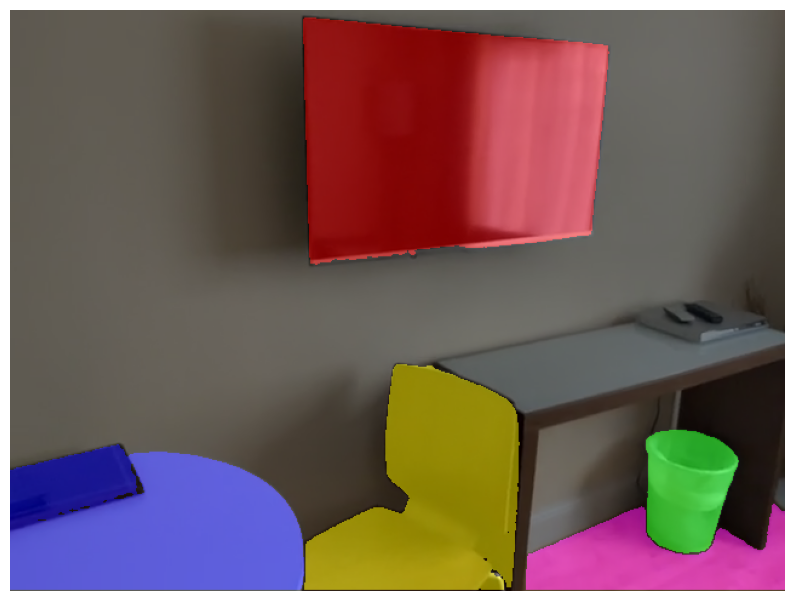

In [206]:
boxes_0 = [
    {k: float(v) for k, v in det["box"].items()}
    for det in grounding_result_0
]
boxes_1 = [
    {k: float(v) for k, v in det["box"].items()}
    for det in grounding_result_1
]
boxes_xyxy = np.array([[b["xmin"], b["ymin"], b["xmax"], b["ymax"]] for b in boxes_1])
#print(boxes)
print([boxes_xyxy])
mask=segment_with_bbox (img1,boxes_xyxy.tolist())
show_instance_masks(img1, mask, alpha=0.5)

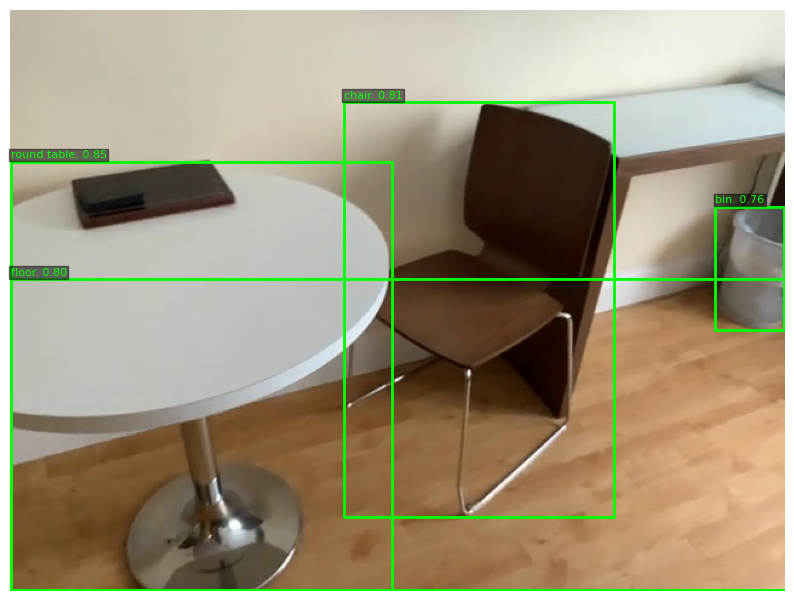

In [207]:
show_grounding(img0, grounding_result_0)

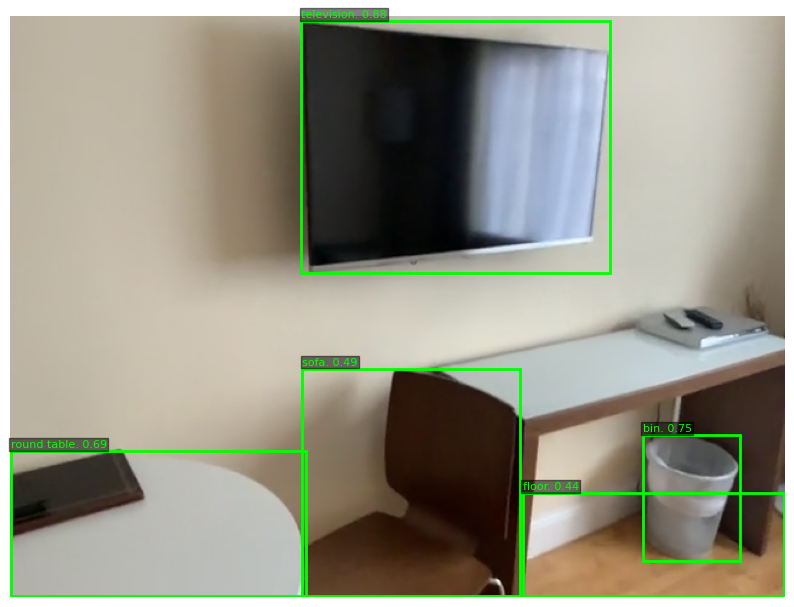

In [208]:
show_grounding(img1, grounding_result_1)

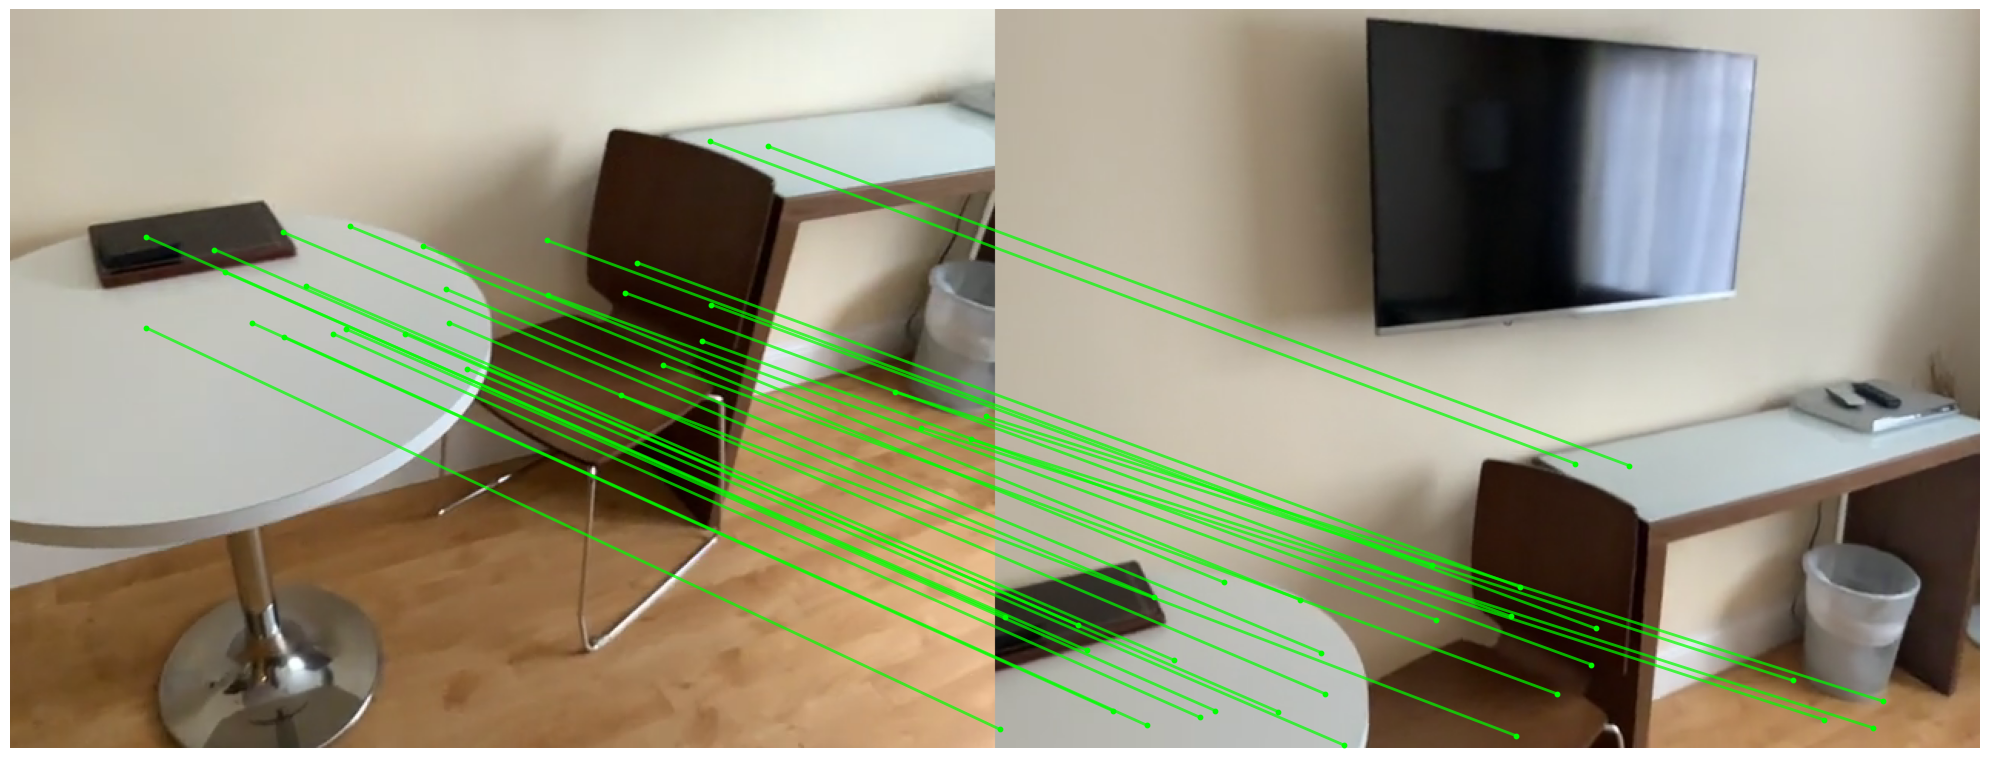

In [209]:
start=1100
end=1130
kA_filt, kB_filt, imA, imB = filter_matches_in_boxes(matches, roma_model, img_path0, img_path1, boxes_0,boxes_1)
if len(kA_filt) == 0:
    print("No matches inside both sets of boxes.")
else:
    visualize_matches(imA, imB, kA_filt[start:end,:], kB_filt[start:end,:], max_plot=500)

#visualize_roma_matches(img_path0, img_path1, matches, roma_model,boxes_0,boxes_1)

In [210]:
kA_filt

array([[239.62964, 148.61111],
       [474.44443, 241.94444],
       [359.38687, 233.97627],
       ...,
       [455.65274, 242.13533],
       [264.81482, 165.83333],
       [134.23224, 153.97147]], shape=(4857, 2), dtype=float32)

In [211]:
depth0, focal_length0=depth_single_frame(img0)
depth1, focal_length1=depth_single_frame(img1)

tensor(728.1863, device='cuda:0')
tensor(801.4220, device='cuda:0')


In [212]:
def depth_to_points(depth, K, step=4):
    """Backproject depth (HxW) to 3D points in camera frame. step subsamples for speed."""
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    h, w = depth.shape
    ys, xs = np.meshgrid(np.arange(0, h, step), np.arange(0, w, step), indexing="ij")
    z = depth[ys, xs]
    x = (xs - cx) * z / fx
    y = (ys - cy) * z / fy
    pts = np.stack([x, y, z], axis=-1).reshape(-1, 3)
    return pts, ys.reshape(-1), xs.reshape(-1)

def rgb_colors_from_image(img, ys, xs):
    """img is HxWx3 uint8; ys/xs are flattened pixel coords."""
    img_np = np.asarray(img)
    return img_np[ys, xs]

def save_points (points,colors,file_name):
    # points: (N,3), colors: (N,3) with values in [0,1] or [0,255]
    points = np.array(points)
    #colors = img.reshape(-1, 3) / 255.0
    if colors.max()<1.1:
        colors = (colors * 255).astype(np.uint8)  # convert to 0-255 if needed
    
    # Create PLY content
    ply_header = f"""ply
    format ascii 1.0
    element vertex {len(points)}
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    """
    
    with open(file_name, "w") as f:
        f.write(ply_header)
        for p, c in zip(points, colors):
            f.write(f"{p[0]} {p[1]} {p[2]} {c[0]} {c[1]} {c[2]}\n")

f_est=720
cx=(W_0-1)/2
cy=(H_0-1)/2

K = np.array([[f_est, 0.0,  cx],
              [0.0,   f_est, cy],
              [0.0,   0.0,   1.0]], dtype=float)

points, ys, xs = depth_to_points(depth1, K, step=1)  # denser -> use step=1
colors = rgb_colors_from_image(img1, ys, xs)
save_points(points, colors, "cloud116_f700.ply")

In [213]:
pp0

array([319.5, 239.5])

In [214]:
mkpts1_y.max()

np.int64(479)

Estimated 4x4 similarity transform (B->A):
 [[ 0.87775988 -0.08059135  0.16920618 -0.2065955 ]
 [ 0.12332116  0.85854876 -0.23081165 -0.019948  ]
 [-0.14112969  0.24897221  0.85069581  0.0069011 ]
 [ 0.          0.          0.          1.        ]]


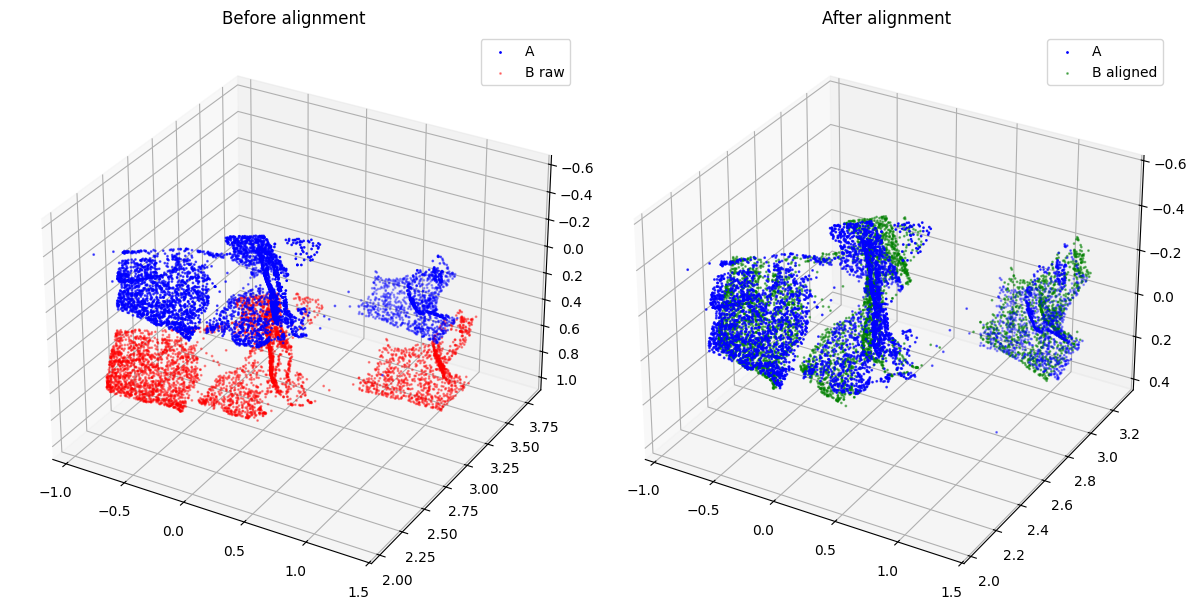

In [215]:
import numpy as np
import matplotlib.pyplot as plt

def pixels_to_points(kpts, depth, f, pp):
    """Backproject pixel coords (x,y) with depth to 3D."""
    kpts = np.asarray(kpts)
    xs = np.clip(np.round(kpts[:, 0]).astype(int), 0, depth.shape[1]-1)
    ys = np.clip(np.round(kpts[:, 1]).astype(int), 0, depth.shape[0]-1)
    z = depth[ys, xs]
    valid = z > 0
    xs, ys, z = xs[valid], ys[valid], z[valid]
    x3d = (xs - pp[0]) * z / f
    y3d = (ys - pp[1]) * z / f
    pts = np.stack([x3d, y3d, z], axis=1)
    return pts

def similarity_transform_3d(src, dst):
    """
    3D analog of the 2D snippet: returns 4x4 T with scale, rotation, translation.
    src, dst: (N,3) matched points.
    """
    src = np.asarray(src, dtype=float)
    dst = np.asarray(dst, dtype=float)
    assert src.shape == dst.shape and src.shape[1] == 3
    mu_s = src.mean(axis=0)
    mu_d = dst.mean(axis=0)
    X = src - mu_s
    Y = dst - mu_d
    S = X.T @ Y / src.shape[0]
    U, _, Vt = np.linalg.svd(S)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T
    var_X = (X**2).sum() / src.shape[0]
    s = np.trace(R @ S) / var_X
    t = mu_d - s * (R @ mu_s)
    T = np.eye(4)
    T[:3, :3] = s * R
    T[:3, 3] = t
    return T

# --- Build point clouds from filtered matches ---
# Replace f_est with focal_length0/focal_length1 if you prefer those.
ptsA = pixels_to_points(kA_filt, depth0, focal_length0, pp0)
ptsB = pixels_to_points(kB_filt, depth1, focal_length1, pp1)

# Ensure we have matched counts after depth validity filter
num = min(len(ptsA), len(ptsB))
ptsA = ptsA[:num]
ptsB = ptsB[:num]

# Estimate transform (B frame -> A frame)
T_BA = similarity_transform_3d(ptsB, ptsA)
print("Estimated 4x4 similarity transform (B->A):\n", T_BA)

# Apply transform to B cloud
ptsB_aligned = (T_BA[:3, :3] @ ptsB.T).T + T_BA[:3, 3]

# --- Visualization ---
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(ptsA[:, 0], ptsA[:, 2], ptsA[:, 1], s=1, c='blue', label='A')
ax1.scatter(ptsB[:, 0], ptsB[:, 2], ptsB[:, 1], s=1, c='red', alpha=0.4, label='B raw')
ax1.set_title("Before alignment"); ax1.legend(); ax1.invert_zaxis()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(ptsA[:, 0], ptsA[:, 2], ptsA[:, 1], s=1, c='blue', label='A')
ax2.scatter(ptsB_aligned[:, 0], ptsB_aligned[:, 2], ptsB_aligned[:, 1],
            s=1, c='green', alpha=0.5, label='B aligned')
ax2.set_title("After alignment"); ax2.legend(); ax2.invert_zaxis()
plt.tight_layout(); plt.show()


In [216]:
from pathlib import Path
import numpy as np

def save_points(points, colors, file_name):
    points = np.asarray(points)
    colors = np.asarray(colors)
    if colors.max() < 1.1:
        colors = (colors * 255).astype(np.uint8)
    ply_header = f"""ply
format ascii 1.0
element vertex {len(points)}
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
"""
    with open(file_name, "w") as f:
        f.write(ply_header)
        for p, c in zip(points, colors):
            f.write(f"{p[0]} {p[1]} {p[2]} {c[0]} {c[1]} {c[2]}\n")

def ensure_rgb(img_np):
    """Return HxWx3 uint8 RGB."""
    if img_np.ndim == 2:  # grayscale -> RGB
        img_np = np.stack([img_np]*3, axis=-1)
    if img_np.shape[2] == 4:  # RGBA -> RGB by dropping alpha
        img_np = img_np[..., :3]
    return img_np.astype(np.uint8)

def full_image_cloud(image_pil, depth, f, pp, step=1):
    img_np = ensure_rgb(np.array(image_pil))
    depth_np = np.array(depth)
    H, W = depth_np.shape
    ys, xs = np.meshgrid(np.arange(0, H, step), np.arange(0, W, step), indexing='ij')
    z = depth_np[ys, xs]
    valid = z > 0
    xs = xs[valid].ravel()
    ys = ys[valid].ravel()
    z = z[valid].ravel()
    x3d = (xs - pp[0]) * z / f
    y3d = (ys - pp[1]) * z / f
    pts = np.stack([x3d, y3d, z], axis=1)
    cols = img_np[ys, xs]  # RGB colors
    return pts, cols

# Build full clouds (set step>1 to downsample if needed)
pts0_full, cols0 = full_image_cloud(img0, depth0, f_est, pp0, step=1)
pts1_full, cols1 = full_image_cloud(img1, depth1, f_est, pp1, step=1)

# Align cloud 1 into cloud 0 frame using T_BA from earlier
RBA = T_BA[:3, :3]
tBA = T_BA[:3, 3]
pts1_aligned = (RBA @ pts1_full.T).T + tBA

# Merge and save
pts_merged = np.vstack([pts0_full, pts1_aligned])
cols_merged = np.vstack([cols0, cols1])

out_dir = Path("clouds")
out_dir.mkdir(exist_ok=True)
merged_path = out_dir / "cloud_merged_53_116.ply"
save_points(pts_merged, cols_merged, merged_path)
print("Saved merged cloud:", merged_path)


Saved merged cloud: clouds/cloud_merged_53_116.ply
